# Hyperparameter Tuning in TensorFlow

In this notebook we will demonstrate how to set up and execute distributed hyperparameter tuning across multiple CPUs and GPUs in TensorFlow. If using an HPC system, the current examples are limited to a single node/machine.

In [1]:
import tensorflow as tf
import os

# Get the number of CPU threads TensorFlow can see
num_cpus = os.cpu_count()
print(f"Number of CPU threads: {num_cpus}")

# Set TensorFlow to use all available CPU threads
tf.config.threading.set_intra_op_parallelism_threads(num_cpus)
tf.config.threading.set_inter_op_parallelism_threads(num_cpus)

# Verify that TensorFlow is using all CPU threads
intra_threads = tf.config.threading.get_intra_op_parallelism_threads()
inter_threads = tf.config.threading.get_inter_op_parallelism_threads()

print(f"Number of intra-op threads TensorFlow is using: {intra_threads}")
print(f"Number of inter-op threads TensorFlow is using: {inter_threads}")

# Check how many GPUs are available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    num_gpus = len(gpus)
    print(f"Number of GPUs: {num_gpus}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {tf.config.experimental.get_device_details(gpu)['device_name']}")
    device = tf.device('/GPU:0')
else:
    device = tf.device('/CPU:0')
    print("Using CPU")


Number of CPU threads: 14
Number of intra-op threads TensorFlow is using: 14
Number of inter-op threads TensorFlow is using: 14
Using CPU


## Create surrogate data

In [2]:
import sklearn.datasets as sdt

# Create surogate data
n_samples = 1000
n_features = 100
n_info = 5
n_targets = 3
noise = 20

x, y = sdt.make_regression(
    n_samples=n_samples, 
    n_features=n_features, 
    n_informative=n_info, 
    n_targets=n_targets, 
    noise=noise, 
    random_state=42,
)
print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Shape of x: (1000, 100), Shape of y: (1000, 3)


## Preprocess data

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Get the normalizers using the sklearn library
x_normalizer, y_normalizer = StandardScaler(), StandardScaler()

# Fit the normalizers
x_normalizer.fit(x)
y_normalizer.fit(y)

# Normalize the data
x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create the train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

## Initialize Ray Tuner

In [4]:
import ray
import tensorflow as tf
from tensorflow.data import Dataset

# Initialize Ray
ray.shutdown()
ray.init()

print("Available resources:", ray.cluster_resources())

batch_size = 32

x_train_id = ray.put(x_train)
y_train_id = ray.put(y_train)
x_val_id = ray.put(x_val)
y_val_id = ray.put(y_val)

y_normalizer_id = ray.put(y_normalizer)


2024-09-18 14:53:26,693	INFO worker.py:1777 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 


Available resources: {'CPU': 14.0, 'node:__internal_head__': 1.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2147483648.0, 'memory': 22350045184.0}


## Create TensorFlow Model

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Dropout, BatchNormalization


class ArtificialNeuralNetwork(Model):
    def __init__(
        self,
        num_features,
        num_outputs,
        node_list = [8, 8, 8],
        act_fun = "relu",
        dropout = 0.0,
        input_dropout = 0.0,
        batch_norm = False,
        l2_reg = 0.0,
        **kwargs,
    ):
        super(ArtificialNeuralNetwork, self).__init__(**kwargs)

        self.num_features = num_features
        self.num_outputs = num_outputs
        self.node_list = node_list
        self.act_fun = act_fun
        self.dropout = dropout
        self.input_dropout = input_dropout
        self.batch_norm = batch_norm
        self.l2_reg = l2_reg

        self.num_layers = len(self.node_list)

        # Create the layers
        self.create_dropout_layers()
        self.create_activation_layers()
        self.create_batch_norm_layers()
        self.create_output_layer()
        self.create_dense_layers()

    def create_dropout_layers(self):
        if self.dropout > 0:
            self.dropout_layers = [
                Dropout(self.dropout, name=f"dropout_{i}") 
                for i in range(self.num_layers)
            
            ]

    def create_activation_layers(self):
        self.activation_layers = [
            Activation(self.act_fun, name=f"activation_{i}") 
            for i in range(self.num_layers)
        ]

    def create_batch_norm_layers(self):
        if self.batch_norm:
            self.batch_norm_layers = [
                BatchNormalization(name=f"batch_norm_{i}") 
                for i in range(self.num_layers)
            ]

    def create_output_layer(self):
        self.output_layer = Dense(self.num_outputs, name="output_layer")

    def create_dense_layers(self):
        self.dense_layers = [
            Dense(
                self.node_list[i],
                activation=None,
                kernel_regularizer=tf.keras.regularizers.l2(self.l2_reg),
                name=f"dense_{i}",
            )
            for i in range(self.num_layers)
        ]

    def call(self, x):

        # Apply input dropout
        if self.input_dropout > 0:
            x = Dropout(self.input_dropout)(x)

        for i in range(self.num_layers):
            x = self.dense_layers[i](x)
            x = self.batch_norm_layers[i](x) if self.batch_norm else x
            x = self.activation_layers[i](x)
            x = self.dropout_layers[i](x) if self.dropout > 0 else x

        return self.output_layer(x)
            



## Create Ray Model Tune Functions

In [14]:
from tensorflow.keras.optimizers import Adam

def model_builder(config):
    act_fun = config["act_fun"]
    dropout = config["dropout"]
    input_dropout = config["input_dropout"]
    batch_norm = config["batch_norm"]
    l2_reg = config["l2_reg"]

    max_depth = config["max_depth"]
    if config["node_list"] is None:
        node_list = [config[f"layer_{i}_width"] for i in range(max_depth) if config[f"layer_{i}_width"] > 0]

    else:
        node_list = config["node_list"]

    # Remove zero width layers
    node_list = [x for x in node_list if x > 0]
    
    learning_rate = config["learning_rate"]
    

    model = ArtificialNeuralNetwork(
        num_features=x_train.shape[1],
        num_outputs=y_train.shape[1],
        node_list=node_list,
        act_fun=act_fun,
        dropout=dropout,
        input_dropout=input_dropout,
        batch_norm=batch_norm,
        l2_reg=l2_reg,
    )
    
    optimizer = Adam(learning_rate=learning_rate)
    
    return model, optimizer

def tune_model(config):
    
    # dl_train = ray.get(dl_train_id)
    # dl_val = ray.get(dl_val_id)
    x_train = ray.get(x_train_id)
    y_train = ray.get(y_train_id)
    x_val = ray.get(x_val_id)
    y_val = ray.get(y_val_id)
    
    # if torch.cuda.is_available():
    #     device = torch.device("cuda")
    # else:
    #     device = torch.device("cpu")
    # print(f"Device: {device}")
    
    # model, optimizer, criterion = model_builder(config)
    model, optimizer = model_builder(config)
    model.compile(optimizer=optimizer, loss="mse")
    
    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=200,
        batch_size=32,
        shuffle=True,
        verbose=0,
    )
    
    val_loss = history.history['val_loss'][-1]
    
    return {"val_loss": val_loss}

## Quick test that the model is working

In [9]:
# test
import time

s_time = time.time()

# if torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("Using GPU:", torch.cuda.get_device_name(0))
# else:
#     device = torch.device("cpu")
#     print("Using CPU")

model, optimizer = model_builder(
    {
        "act_fun": "relu",
        "dropout": 0.1,
        "input_dropout": 0.1,
        "batch_norm": False,
        "l2_reg": 0.0,
        "learning_rate": 1e-3,
        "node_list": [32, 32],
        # "node_list": [],
        "max_depth": 2,
    }
)
model.compile(optimizer=optimizer, loss="mse")
model.build(input_shape=(None, x_train.shape[1]))
model.summary()

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=32,
    shuffle=True,
    verbose=1,
)

print(f"Elapsed time: {time.time() - s_time}")

Model: "artificial_neural_network_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_0 (Dropout)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 activation_0 (Activation)   multiple                  0         
                                                                 
 activation_1 (Activation)   multiple                  0         
                                                                 
 output_layer (Dense)        multiple                  99        
                                                                 
 dense_0 (Dense)             multiple                  3232      
                                                                 
 dense_1 (Dense)             multiple  

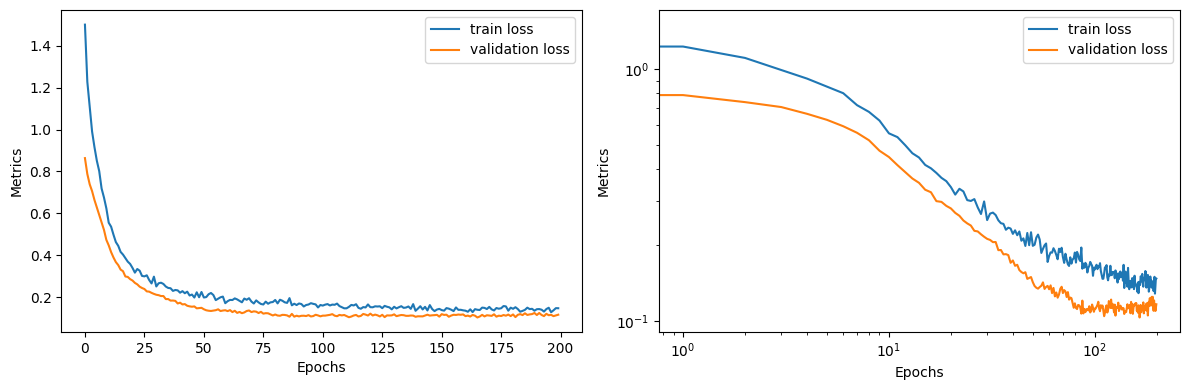

In [10]:
from tfmelt.utils.visualization import plot_history
plot_history(history, metrics=["loss"], plot_log=True)

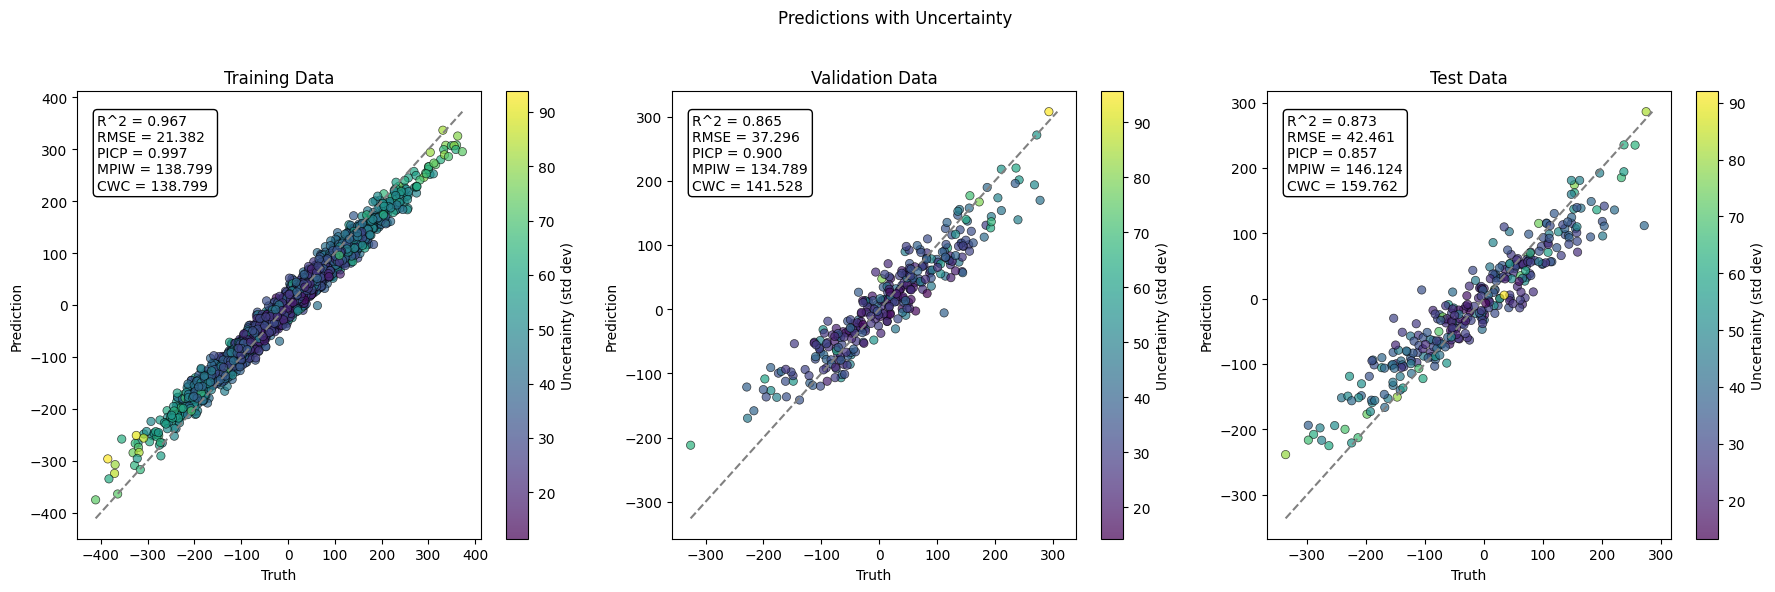

In [11]:
from tfmelt.utils.evaluation import ensemble_predictions
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Necessary to be consistent with tf-melt prediction routines
model.num_mixtures = 0
ensmeble_size = 100
training = True # needed for monte carlo dropout evaluation
####

pred_mean_train, pred_std_train = ensemble_predictions(model, x_train, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training) 
pred_mean_test, pred_std_test = ensemble_predictions(model, x_test, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)
pred_mean_val, pred_std_val = ensemble_predictions(model, x_val, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)

plot_predictions_with_uncertainty(
    pred_mean_train, pred_std_train, y_train_real,
    pred_mean_val, pred_std_val, y_val_real,
    pred_mean_test, pred_std_test, y_test_real,
    metrics_to_display=["R^2", "RMSE", "PICP", "MPIW", "CWC"],
)

## Set hyperparameter variables

In [15]:
import random
import numpy as np
from ray import tune
from ray.tune.schedulers import ASHAScheduler

# Create a list of dropout values
dropout_values = np.arange(0, 0.55, 0.05).tolist()
node_values = [0, 8, 32, 128, 512]

max_depth = 3

config = {
    "act_fun": tune.choice(["relu", "elu"]),
    "batch_norm": tune.choice([True, False]),
    # "l2_reg": tune.choice([0.0, 1e-3]),
    "l2_reg": 0.0,
    "learning_rate": tune.choice([1e-3, 3e-4, 1e-4]),
    "dropout": tune.choice(dropout_values),
    "input_dropout": tune.choice(dropout_values),
    # "node_list":tune.choice([[32, 32], [64, 64], [128, 128], [256, 256]]),
    # "max_depth": 2,
    **{f"layer_{i}_width": tune.choice(node_values) for i in range(max_depth)},
    "max_depth": max_depth,
    "node_list": None,
}

asha = ASHAScheduler(
    metric="val_loss",
    mode="min",
    max_t=200,  # Maximum number of epochs
    grace_period=10, # Number of epochs to wait before stopping a trial
    reduction_factor=2,
)

## Run the tuner

In [16]:
asha_analysis = tune.run(
    tune.with_parameters(tune_model),
    config=config,
    num_samples=56,
    scheduler=asha,
    verbose=1,
    # resources_per_trial={"cpu": 1, "gpu": 1},
    resources_per_trial={"cpu": 1, "gpu": 0},
)

2024-09-18 14:58:31,869	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/nwimer/ray_results/tune_model_2024-09-18_14-57-03' in 0.0172s.
2024-09-18 14:58:31,876	INFO tune.py:1041 -- Total run time: 88.71 seconds (88.67 seconds for the tuning loop).


## Get the best model parameters from the tuning

In [17]:
best_asha = asha_analysis.get_best_config(metric="val_loss", mode="min")
print("Best hyperparameters found were: ", best_asha)

Best hyperparameters found were:  {'act_fun': 'elu', 'batch_norm': True, 'l2_reg': 0.0, 'learning_rate': 0.001, 'dropout': 0.25, 'input_dropout': 0.0, 'layer_0_width': 128, 'layer_1_width': 512, 'layer_2_width': 32, 'max_depth': 3, 'node_list': None}


## Build the model from the best hyperparameters and train from scratch

In [18]:
best_model, optimizer = model_builder(best_asha)
best_model.compile(optimizer=optimizer, loss="mse")
best_model.build(input_shape=(None, x_train.shape[1]))
best_model.summary()

history = best_model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=32,
    shuffle=True,
)

Model: "artificial_neural_network_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_0 (Dropout)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 activation_0 (Activation)   multiple                  0         
                                                                 
 activation_1 (Activation)   multiple                  0         
                                                                 
 activation_2 (Activation)   multiple                  0         
                                                                 
 batch_norm_0 (BatchNormali  multiple  

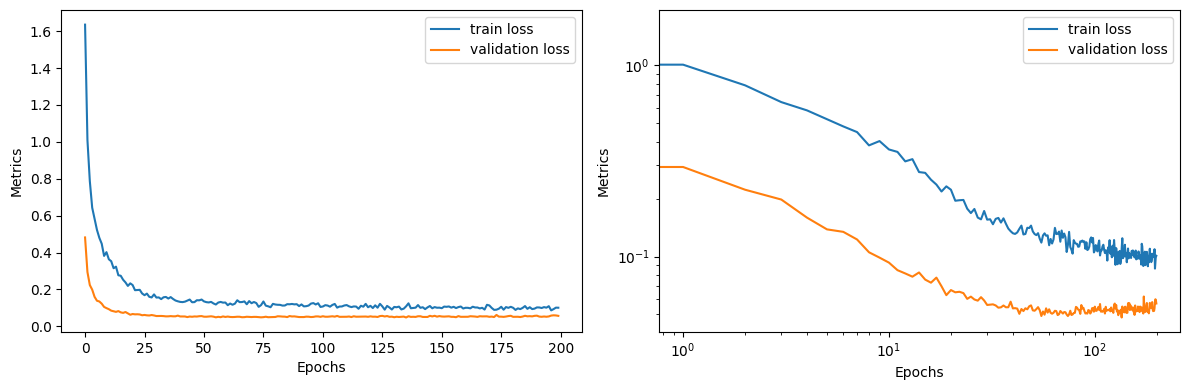

In [20]:
from tfmelt.utils.visualization import plot_history
plot_history(history, metrics=["loss"], plot_log=True)

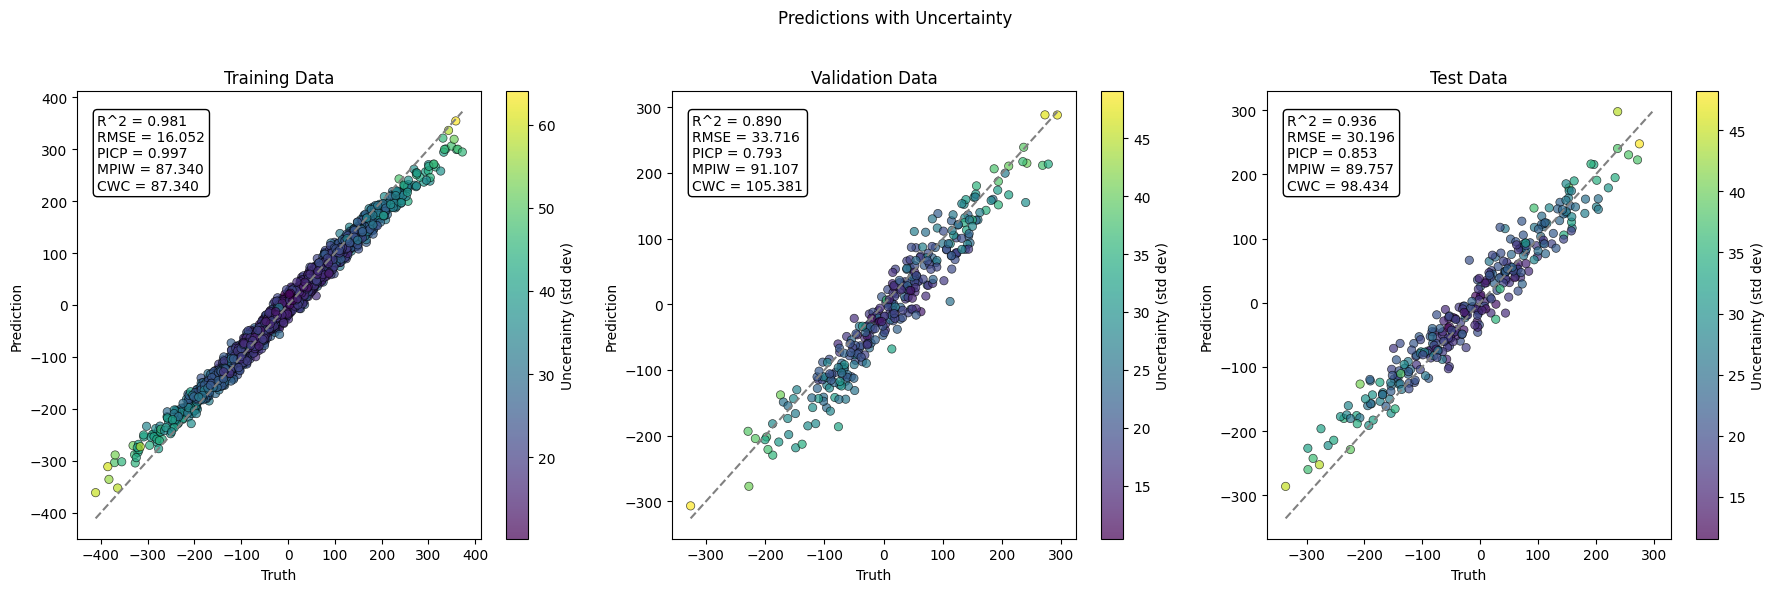

In [21]:
from tfmelt.utils.evaluation import ensemble_predictions
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Necessary to be consistent with tf-melt prediction routines
best_model.num_mixtures = 0
ensmeble_size = 100
training = True # needed for monte carlo dropout evaluation
####

pred_mean_train, pred_std_train = ensemble_predictions(best_model, x_train, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training) 
pred_mean_test, pred_std_test = ensemble_predictions(best_model, x_test, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)
pred_mean_val, pred_std_val = ensemble_predictions(best_model, x_val, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)

plot_predictions_with_uncertainty(
    pred_mean_train, pred_std_train, y_train_real,
    pred_mean_val, pred_std_val, y_val_real,
    pred_mean_test, pred_std_test, y_test_real,
    metrics_to_display=["R^2", "RMSE", "PICP", "MPIW", "CWC"],
)

## Try modifying the hyperparameter fit function

In [22]:
from tfmelt.utils.statistics import compute_cwc, compute_picp

def tune_model(config):
    
    x_train = ray.get(x_train_id)
    y_train = ray.get(y_train_id)
    x_val = ray.get(x_val_id)
    y_val = ray.get(y_val_id)
    
    
    # model, optimizer, criterion = model_builder(config)
    model, optimizer = model_builder(config)
    model.compile(optimizer=optimizer, loss="mse")
    
    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_val, y_val),
        epochs=200,
        batch_size=32,
        shuffle=True,
        verbose=0,
    )
    
    val_loss = history.history['val_loss'][-1]

    # Add in UQ metric as objective
    pred_mean_val, pred_std_val = ensemble_predictions(model, x_val, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)
    val_cwc = compute_cwc(y_val_real, pred_mean_val, pred_std_val)
    val_picp = compute_picp(y_val_real, pred_mean_val, pred_std_val)
    
    return {"val_loss": val_loss, "val_cwc": val_cwc, "val_picp": val_picp}

In [23]:
asha_cwc = ASHAScheduler(
    # metric="val_cwc",
    # mode="min",
    # metric="val_loss",
    metric="val_picp",
    mode="max",
    max_t=200,  # Maximum number of epochs
    grace_period=10, # Number of epochs to wait before stopping a trial
    reduction_factor=3,
)

In [24]:
asha_analysis = tune.run(
    tune.with_parameters(tune_model),
    config=config,
    num_samples=56,
    scheduler=asha_cwc,
    verbose=1,
    # resources_per_trial={"cpu": 1, "gpu": 1},
    resources_per_trial={"cpu": 1, "gpu": 0},
)

2024-09-18 15:58:35,170	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/nwimer/ray_results/tune_model_2024-09-18_15-57-01' in 0.0166s.
2024-09-18 15:58:35,177	INFO tune.py:1041 -- Total run time: 93.42 seconds (93.38 seconds for the tuning loop).


In [25]:
best_asha = asha_analysis.get_best_config(metric="val_loss", mode="min")
print("Best hyperparameters found were: ", best_asha)

Best hyperparameters found were:  {'act_fun': 'elu', 'batch_norm': True, 'l2_reg': 0.0, 'learning_rate': 0.0003, 'dropout': 0.45, 'input_dropout': 0.0, 'layer_0_width': 512, 'layer_1_width': 128, 'layer_2_width': 0, 'max_depth': 3, 'node_list': None}


In [26]:
best_model, optimizer = model_builder(best_asha)
best_model.compile(optimizer=optimizer, loss="mse")
best_model.build(input_shape=(None, x_train.shape[1]))
best_model.summary()

history = best_model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=32,
    shuffle=True,
)

Model: "artificial_neural_network_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_0 (Dropout)         multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 activation_0 (Activation)   multiple                  0         
                                                                 
 activation_1 (Activation)   multiple                  0         
                                                                 
 batch_norm_0 (BatchNormali  multiple                  2048      
 zation)                                                         
                                                                 
 batch_norm_1 (BatchNormali  multiple                  512       
 zation)                               

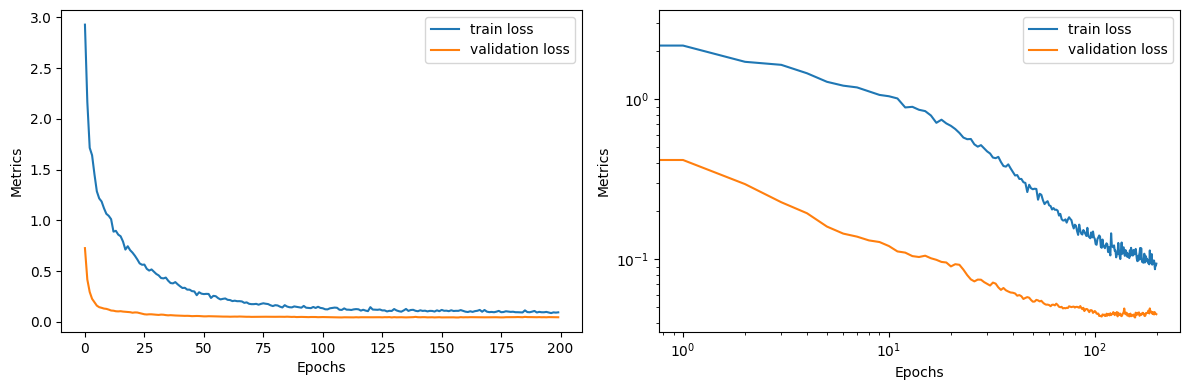

In [27]:
from tfmelt.utils.visualization import plot_history
plot_history(history, metrics=["loss"], plot_log=True)

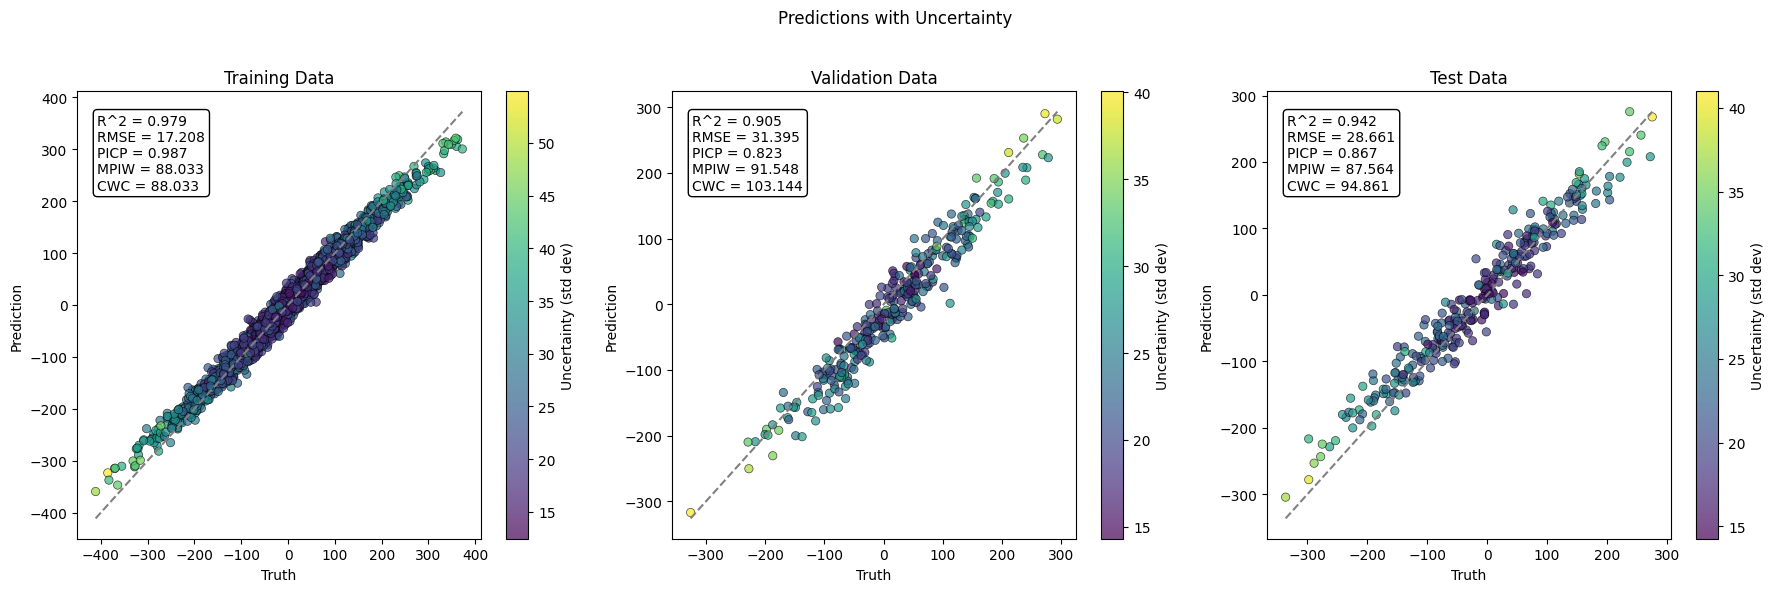

In [28]:
from tfmelt.utils.evaluation import ensemble_predictions
from tfmelt.utils.visualization import plot_predictions_with_uncertainty

# Necessary to be consistent with tf-melt prediction routines
best_model.num_mixtures = 0
ensmeble_size = 100
training = True # needed for monte carlo dropout evaluation
####

pred_mean_train, pred_std_train = ensemble_predictions(best_model, x_train, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training) 
pred_mean_test, pred_std_test = ensemble_predictions(best_model, x_test, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)
pred_mean_val, pred_std_val = ensemble_predictions(best_model, x_val, y_normalizer, unnormalize=True, n_iter=ensmeble_size, training=training)

plot_predictions_with_uncertainty(
    pred_mean_train, pred_std_train, y_train_real,
    pred_mean_val, pred_std_val, y_val_real,
    pred_mean_test, pred_std_test, y_test_real,
    metrics_to_display=["R^2", "RMSE", "PICP", "MPIW", "CWC"],
)